In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import json
from tqdm import tqdm,tqdm_notebook
# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

import os
print(os.listdir("../input"))

# Any results you write to the current directory are saved as output.

['test', 'sample_submission.csv', 'train.csv', 'train']


(17500, 2)
(32, 32, 3)


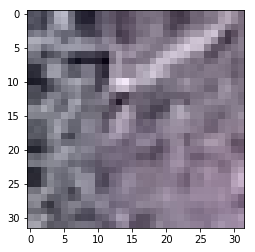

In [2]:
train_df=pd.read_csv("../input/train.csv")
train_df["has_cactus"]=train_df["has_cactus"].map(lambda x:str(x))
print(train_df.shape)

import cv2
image=cv2.imread("../input/train/train/01e30c0ba6e91343a12d2126fcafc0dd.jpg"
                )
plt.imshow(image)
print(image.shape)

In [13]:
from keras.models import Sequential
from keras.layers import Activation,Dropout,Flatten,Dense,MaxPooling2D
from keras.applications import ResNet50
from keras.optimizers import Adam
from keras.models import Model
from keras import regularizers

In [17]:
base_model=ResNet50(weights="imagenet",include_top=False,input_shape=(32,32,3))

/opt/conda/lib/python3.6/site-packages/keras_applications/resnet50.py:265: UserWarning: The output shape of `ResNet50(include_top=False)` has been changed since Keras 2.2.0.
  warnings.warn('The output shape of `ResNet50(include_top=False)` '


In [22]:
def add_new_layer(base_model):
    x=base_model.output
    x=Flatten()(x)
    x=Dense(512,activation="relu")(x)
    predictions = Dense(1, activation='sigmoid',activity_regularizer=regularizers.l1(0.05))(x)
    model = Model(input=base_model.input, output=predictions)
    return model
def transfer_learn(model, base_model):
    for layer in base_model.layers:
        layer.trainable = True
    model.compile(optimizer=Adam(lr=1e-5), loss='binary_crossentropy',
                  metrics=['accuracy'])

In [9]:
from keras.preprocessing.image import ImageDataGenerator
train_datagen=ImageDataGenerator(rescale=1./255,
                                 validation_split=0.1,
                                 rotation_range=30,
                                 shear_range=0.2,
                                 horizontal_flip=True,
                                 vertical_flip=True,
                                 zoom_range=0.2)
train_generator=train_datagen.flow_from_dataframe(
    dataframe=train_df,
    directory="../input/train/train",
    x_col="id",
    y_col="has_cactus",
    batch_size=32,
    shuffle=True,
    class_mode="binary",
    target_size=(32,32),
    subset='training')

validation_generator=train_datagen.flow_from_dataframe(
    dataframe=train_df,
    directory="../input/train/train",
    x_col="id",
    y_col="has_cactus",
    batch_size=32,
    shuffle=True,
    class_mode="binary",
    target_size=(32,32),
    subset='validation')

Found 15750 images belonging to 2 classes.
Found 1750 images belonging to 2 classes.


In [23]:
model=add_new_layer(base_model)

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:6: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("de...)`
  


In [24]:
print(model.summary())

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 32, 32, 3)    0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 38, 38, 3)    0           input_2[0][0]                    
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 16, 16, 64)   9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, 16, 16, 64)   256         conv1[0][0]                      
__________________________________________________________________________________________________
activation

In [26]:
transfer_learn(model, base_model)

In [27]:
history=model.fit_generator(generator=train_generator,
                            validation_data=validation_generator,
                            validation_steps=int(train_df.shape[0]/32),
                            steps_per_epoch=int(train_df.shape[0]/32),
                            epochs=200,
                            verbose=2)

Instructions for updating:
Use tf.cast instead.
Epoch 1/1
 - 106s - loss: 1.3175 - acc: 0.7596 - val_loss: 1.2013 - val_acc: 0.8377


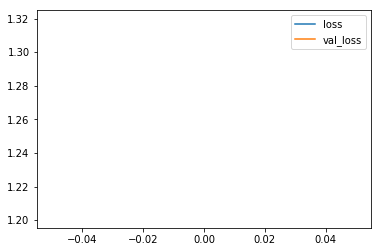

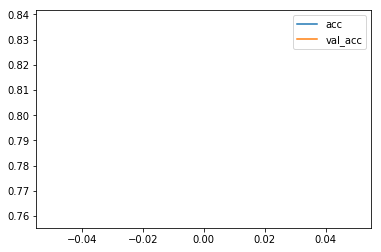

In [28]:
history_df = pd.DataFrame(history.history)
history_df[['loss', 'val_loss']].plot()
history_df[['acc', 'val_acc']].plot()

In [29]:
train_dir=r"../input/train/train/"
test_dir=r"../input/test/test/"
X_test=[]
X_image=[]
for image in tqdm_notebook(os.listdir(test_dir)):
    im=cv2.imread(test_dir+image)
    X_test.append(im)
    X_image.append(image)
X_test=np.array(X_test)
X_test=X_test/255.0

In [30]:
print(X_test.shape)

(4000, 32, 32, 3)


In [31]:
test_predictions=model.predict(X_test)

In [32]:
submission=pd.DataFrame(test_predictions,columns=['has_cactus'])

In [33]:
submission['id'] = ''
cols=list(submission.columns)
cols = cols[-1:] + cols[:-1]
submission=submission[cols]
for i, img in enumerate(X_image):
    submission.set_value(i,'id',img)
print(submission)

                                        id  has_cactus
0     79ac4cc3b082e0a1defe1be601806efd.jpg    0.765203
1     e880364d6521c6f3a27748ec62b0e335.jpg    0.889707
2     74912492b6cdf28c4bfb9c8e1d35af3e.jpg    0.690593
3     078cfa961183b30693ea2f13f5ff6d17.jpg    0.607391
4     7fd729184ef182899ce3e7a174fb9bc0.jpg    0.351828
5     2b5f23aba5af7bdffa13d7fc87cfd704.jpg    0.412907
6     56252603457e38c4b9d539d6a3be380d.jpg    0.976206
7     3a5657d140458ae32c2780818b51a0b2.jpg    0.611850
8     1bf2e11a8d218c3795202270a942705c.jpg    0.835500
9     60515ac7f73add1c96f360b21f45a944.jpg    0.003401
10    a72f4468dfe498bcac525978f33efd44.jpg    0.807181
11    017396273d436137bbecaeb650dca415.jpg    0.109477
12    9abfa27735f7b07db4937edb849f6678.jpg    0.034587
13    ce17e6f73cf2f24f914fd540cc7be31d.jpg    0.493979
14    01cd51bb115fe5c0c37acd8d8800613e.jpg    0.559470
15    6006eda8373b6ec4a7877a59e207db54.jpg    0.766902
16    2171d681af7ca40162e75d6541578cc4.jpg    0.663479
17    7a30

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:6: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  


In [34]:
submission.to_csv('submission.csv',index=False)

In [35]:
print(submission.head())

                                     id  has_cactus
0  79ac4cc3b082e0a1defe1be601806efd.jpg    0.765203
1  e880364d6521c6f3a27748ec62b0e335.jpg    0.889707
2  74912492b6cdf28c4bfb9c8e1d35af3e.jpg    0.690593
3  078cfa961183b30693ea2f13f5ff6d17.jpg    0.607391
4  7fd729184ef182899ce3e7a174fb9bc0.jpg    0.351828
